In [1]:
import pandas as pd
import polars as pl
import numpy as np
import os
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import pickle

from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor
import lightgbm as lgb
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [2]:
class CONFIG:
    seed = 42
    target_col = "responder_6"
    feature_cols = ["symbol_id", "time_id"] \
        + [f"feature_{idx:02d}" for idx in range(79)] \
        + [f"responder_{idx}_lag_1" for idx in range(9)]
    categorical_cols = []

In [3]:
pre_train_score = 0
pre_valid_score = 0

In [4]:
##del feature
col = ['feature_09', 'feature_10', 'feature_11', 'feature_63', 'feature_64', 'feature_41', 'feature_43', 'feature_16', 'feature_71', 'feature_40',
      'feature_76', 'feature_62', 'feature_78']
for c in col:
    CONFIG.feature_cols.remove(c)

In [5]:
train = pl.scan_parquet("./training.parquet").collect().to_pandas()
valid = pl.scan_parquet("./validation.parquet").collect().to_pandas()
train.shape, valid.shape

((10428264, 104), (527560, 104))

In [6]:
# Trick of boosting LB score: 0.45->0.49
train = pd.concat([train, valid]).reset_index(drop=True)
train.shape

(10955824, 104)

In [7]:
def get_model(seed):
    XGB_Params = {
        'gpu_id': 0,
        'tree_method': 'gpu_hist', 
        'max_depth': 12, 
        'learning_rate': 0.007231989605416156, 
        'n_estimators': 946, 
        'min_child_weight': 6, 
        'subsample': 0.7821755857126507, 
        'colsample_bytree': 0.6349315226098992, 
        'reg_alpha': 2.8193682122436093e-07, 
        'reg_lambda': 4.7205986341463775e-07
    }
    XGB_Model = XGBRegressor(**XGB_Params)
    return XGB_Model

In [8]:
def get_model(seed):
    # XGBoost parameters
    XGB_Params = {
                  'gpu_id': 0,
                  'tree_method': 'gpu_hist', 
                   'subsample': 0.7, 
                  'reg_lambda': 5, 
                  'reg_alpha': 2, 
                  'random_state': 42, 
                  'n_estimators': 200, 
                  'max_depth': 6, 
                  'learning_rate': 0.02, 
                  'colsample_bytree': 0.8}
    XGB_Model = XGBRegressor(**XGB_Params)
    return XGB_Model

In [8]:
X_train = train[ CONFIG.feature_cols ]
y_train = train[ CONFIG.target_col ]
w_train = train[ "weight" ]
X_valid = valid[ CONFIG.feature_cols ]
y_valid = valid[ CONFIG.target_col ]
w_valid = valid[ "weight" ]

X_train.shape, y_train.shape, w_train.shape, X_valid.shape, y_valid.shape, w_valid.shape

((10955824, 77), (10955824,), (10955824,), (527560, 77), (527560,), (527560,))

In [9]:
%%time
model = get_model(CONFIG.seed)
model.fit( X_train, y_train, sample_weight=w_train)

CPU times: total: 5min 20s
Wall time: 6min 3s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6349315226098992, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=0,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.007231989605416156,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=946, n_jobs=None,
             num_parallel_tree=None, ...)

In [10]:
y_pred_train1 = model.predict(X_train.iloc[:X_train.shape[0]//2])
y_pred_train2 = model.predict(X_train.iloc[X_train.shape[0]//2:])
train_score = r2_score(y_train, np.concatenate([y_pred_train1, y_pred_train2], axis=0), sample_weight=w_train )
print(pre_train_score)
print(train_score)
pre_train_score = train_score

0
0.19605176725225337


In [11]:
y_pred_valid = model.predict(X_valid)
valid_score = r2_score(y_valid, y_pred_valid, sample_weight=w_valid )
print(pre_valid_score)
print(valid_score)
pre_valid_score = valid_score

0
0.09832159736637469


In [ ]:
0.0030196481257540597
0.006296937604060582

In [15]:
y_means = { symbol_id : -1 for symbol_id in range(39) }
for symbol_id, gdf in train[["symbol_id", CONFIG.target_col]].groupby("symbol_id"):
    y_mean = gdf[ CONFIG.target_col ].mean()
    y_means[symbol_id] = y_mean
    print(f"symbol_id = {symbol_id}, y_means = {y_mean:.5f}")

symbol_id = 0, y_means = -0.00706
symbol_id = 1, y_means = -0.00856
symbol_id = 2, y_means = 0.00451
symbol_id = 3, y_means = 0.01523
symbol_id = 4, y_means = 0.01331
symbol_id = 5, y_means = 0.00868
symbol_id = 6, y_means = 0.00996
symbol_id = 7, y_means = -0.00055
symbol_id = 8, y_means = -0.00560
symbol_id = 9, y_means = -0.05171
symbol_id = 10, y_means = 0.00283
symbol_id = 11, y_means = -0.00581
symbol_id = 12, y_means = -0.00283
symbol_id = 13, y_means = -0.00820
symbol_id = 14, y_means = -0.00844
symbol_id = 15, y_means = 0.00799
symbol_id = 16, y_means = -0.00740
symbol_id = 17, y_means = -0.00381
symbol_id = 18, y_means = -0.01093
symbol_id = 19, y_means = 0.01338
symbol_id = 20, y_means = 0.00982
symbol_id = 21, y_means = 0.01602
symbol_id = 22, y_means = -0.00410
symbol_id = 23, y_means = 0.01738
symbol_id = 24, y_means = -0.00286
symbol_id = 25, y_means = -0.02394
symbol_id = 26, y_means = -0.00495
symbol_id = 27, y_means = -0.01014
symbol_id = 28, y_means = 0.00009
symbol_

In [16]:
cv_detail = { symbol_id : 0 for symbol_id in range(39) }
for symbol_id, gdf in valid.groupby("symbol_id"):
    X_valid = gdf[ CONFIG.feature_cols ]
    y_valid = gdf[ CONFIG.target_col ]
    w_valid = gdf[ "weight" ]
    y_pred_valid = model.predict(X_valid)
    score = r2_score(y_valid, y_pred_valid, sample_weight=w_valid )
    cv_detail[symbol_id] = score
    
    print(f"symbol_id = {symbol_id}, score = {score:.5f}")

symbol_id = 0, score = 0.09440
symbol_id = 1, score = 0.10240
symbol_id = 2, score = 0.06532
symbol_id = 3, score = 0.06015
symbol_id = 4, score = 0.18162
symbol_id = 5, score = 0.08472
symbol_id = 6, score = 0.02313
symbol_id = 7, score = 0.18747
symbol_id = 8, score = 0.07305
symbol_id = 9, score = 0.05075
symbol_id = 10, score = 0.03056
symbol_id = 11, score = 0.04422
symbol_id = 12, score = 0.14859
symbol_id = 13, score = 0.07495
symbol_id = 14, score = 0.02566
symbol_id = 15, score = 0.06157
symbol_id = 16, score = 0.13597
symbol_id = 17, score = 0.15349
symbol_id = 18, score = 0.06677
symbol_id = 19, score = 0.20647
symbol_id = 20, score = 0.12566
symbol_id = 21, score = 0.05647
symbol_id = 22, score = 0.04374
symbol_id = 23, score = 0.09803
symbol_id = 24, score = 0.10273
symbol_id = 25, score = 0.07819
symbol_id = 26, score = 0.06118
symbol_id = 27, score = 0.12147
symbol_id = 28, score = 0.03585
symbol_id = 29, score = 0.06965
symbol_id = 30, score = 0.04507
symbol_id = 31, sc

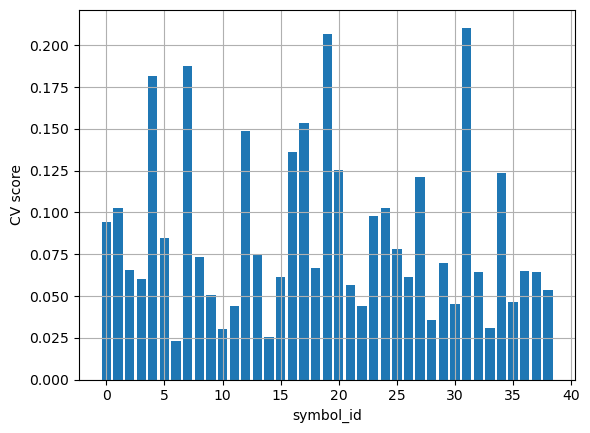

In [17]:
#before
sids = list(cv_detail.keys())
plt.bar(sids, [cv_detail[sid] for sid in sids])
plt.grid()
plt.xlabel("symbol_id")
plt.ylabel("CV score")
plt.show()

In [18]:
result = {
    "model" : model,
    "cv" : valid_score,
    "cv_detail" : cv_detail,
    "y_mean" : y_means,
}
with open("result.pkl", "wb") as fp:
    pickle.dump(result, fp)